# Языковое моделирование

![](https://upload.wikimedia.org/wikipedia/commons/7/75/Sign_language_alphabet_%284%29.jpg 'Raziakhatun12')

В данном проекте мы будем заниматься языковым моделированием. Обучим несколько нейросетевых моделей предсказывать слова на основе предыдущего текста. Такие модели можно будет использовать и для генерации текста. Качество предсказаний будем оценивать по [перплексии](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%BF%D0%BB%D0%B5%D0%BA%D1%81%D0%B8%D1%8F). Обучать модели будем на наборе данных, составленном из комментариев на сервисе [IMDB](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [1]:
from collections import Counter

import lightning as L

from torchmetrics.text.perplexity import Perplexity

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm, trange
from datasets import load_dataset

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

import plotly.express as px

import fasttext

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
L.seed_everything(42)

Global seed set to 42


42

In [4]:
torch.set_float32_matmul_precision('high')

## Подготовка данных

Загрузим данные. Для этого воспользуемся библиотекой `datasets` проекта [`huggingface`](huggingface.co/).

In [5]:
dataset = load_dataset('imdb')

Found cached dataset imdb (/home/dev/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотрим на загруженные данные.

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

В нашем наборе данных уже выделены обучающая и тестовая части, каждая содержит по 25 тысяч комментариев. Информация в блоке `label` нам не важна, так как мы не планируем классифицировать комментарии.

Обработаем данные и создадим словарь. Для начала нам нужно разделить все комментарии на отдельные предложения, именно на них мы будем учиться.

In [7]:
sentences_train = [nltk.sent_tokenize(text.replace("<br /><br />", " ")) for text in tqdm(dataset['train']['text'])]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
sentences_train = [sentence for sentences in sentences_train for sentence in sentences]

Посмотрим на длину наших предложений. Слишком длинные предложения будет сложно моделировать, поэтому их лучше отбросить.

In [9]:
sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in tqdm(sentences_train)]

  0%|          | 0/311534 [00:00<?, ?it/s]

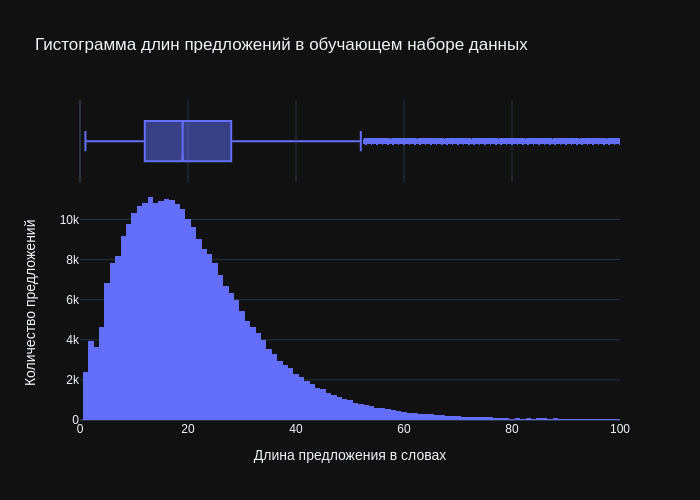

In [10]:
fig = px.histogram(sentence_lengths, template='plotly_dark',marginal='box',
             title='Гистограмма длин предложений в обучающем наборе данных', 
                   labels={'value': 'Длина предложения в словах'})
fig.update_xaxes(range = [0, 100])
fig.update_layout(yaxis_title='Количество предложений')
fig.update_layout(showlegend=False)
fig.show('png')

In [11]:
np.quantile(sentence_lengths, 0.8)

30.0

Похоже, мы можем отбросить предложения длиной более 30 слов и у нас всё равно будет достаточно предложений для обучения.

In [12]:
sentences_train = [sentence.lower() for sentence in tqdm(sentences_train) if len(nltk.word_tokenize(sentence)) < 30]

  0%|          | 0/311534 [00:00<?, ?it/s]

In [13]:
print("Всего предложений:", len(sentences_train))

Всего предложений: 243954


Проведём аналогичные операции для тестового набора данных.

In [14]:
sentences_test = [nltk.sent_tokenize(text.replace("<br /><br />", " ")) for text in tqdm(dataset['test']['text'])]
sentences_test = [sentence for sentences in sentences_test for sentence in sentences]
sentences_test = [sentence.lower() for sentence in tqdm(sentences_test) if len(nltk.word_tokenize(sentence)) < 30]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/305221 [00:00<?, ?it/s]

Хорошо. Теперь можно создать словарь часто встречающихся в обучающей выборке слов.

In [15]:
words = Counter()

for sentence in tqdm(sentences_train):
    for word in nltk.word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/243954 [00:00<?, ?it/s]

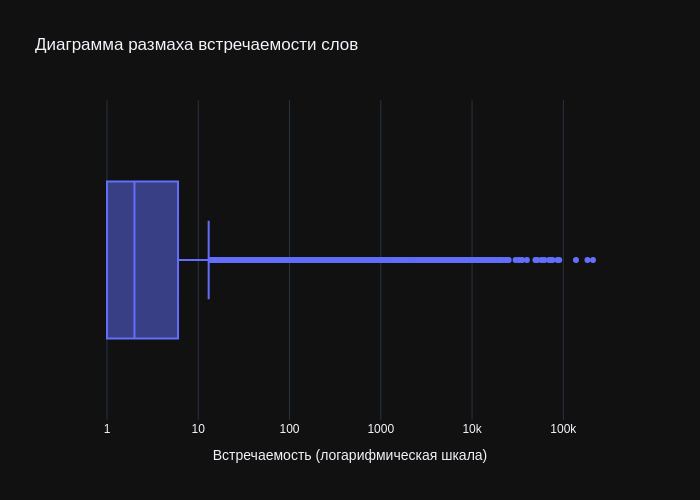

In [16]:
fig = px.box(words.values(), template='plotly_dark', log_x=True, orientation='h', 
             title='Диаграмма размаха встречаемости слов', labels={'value': 'Встречаемость (логарифмическая шкала)'})
fig.update_yaxes(visible=False)
fig.show('png')

In [17]:
len(words)

72852

Похоже, что огромное количество слов встречается в предложениях всего несколько раз и для ускорения обучения от них можно избавиться. Оставим в нашем словаре сорок тысяч наиболее употребимых слов.

In [18]:
vocab_size = 40000
vocab = set([word for word, _ in words.most_common(vocab_size)])

Добавим в словарь служебные слова-токены:
* `<unk>` — токен для замены слов, отсутствующих в словаре *(unknown)*
* `<bos>` — токен начала предложения *(begin of sentence)*
* `<eos>` — токен конца предложения *(end of sentence)*
* `<pad>` — токен паддинга *(padding)*

In [19]:
vocab.update(['<unk>', '<bos>', '<eos>', '<pad>'])

Словарь готов, создадим отдельные файлы-индексаторы.

In [20]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

## Модуль данных

Мы готовы сделать модуль с данными. Мы хотим, чтобы модель получала индексы слов, а затем выдавала индекс следующего слова. Поэтому для каждого предложения мы будем последовательно подавать модели индексы всех слов, кроме последнего, а результаты модели будем сравнивать с последовательными индексами всех слов предложения, исключая первое.

In [21]:
class WordDataset:
    def __init__(self, sentences: list, word2ind: dict) -> None:
        self.data = sentences
        self.word2ind = word2ind
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> list[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence.extend([self.word2ind.get(word, self.unk_id) for word in nltk.word_tokenize(self.data[idx])])
        tokenized_sentence.append(self.eos_id)

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [22]:
def collate_fn_with_padding(input_batch: list[list[int]], 
                            pad_id: int = word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch)

    new_batch = {'input_ids': sequences[:,:-1],
                 'target_ids': sequences[:,1:]}

    return new_batch

In [23]:
BATCH_SIZE = 128

In [24]:
class IMDBDataModule(L.LightningDataModule):
    def __init__(self, train_data: list[str], test_data: list[str], word2ind: dict, batch_size: int = BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.train_data = train_data
        self.val_data, self.test_data = train_test_split(test_data, test_size=0.5, random_state=42)
        self.word2ind = word2ind

    def setup(self, stage: str):
        self.train_dataset = WordDataset(self.train_data, word2ind=self.word2ind)
        self.val_dataset = WordDataset(self.val_data, word2ind=self.word2ind)
        self.test_dataset = WordDataset(self.test_data, word2ind=self.word2ind)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=True, 
                          num_workers=8, 
                          pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=False, 
                          num_workers=8, 
                          pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=False, 
                          num_workers=8, 
                          pin_memory=True)


In [25]:
data_module = IMDBDataModule(train_data=sentences_train,
                             test_data=sentences_test,
                             word2ind=word2ind,
                             batch_size=BATCH_SIZE)

Модуль данных готов, можно приступать к созданию моделей.

## Построение и обучение моделей

Чтобы учесть склонность рекуррентных моделей в взрыву градиентов, будем применять методику gradient clipping.

### Базовая модель

Опишем базовый класс модели, с которым будем производить эксперименты. Мы хотим применить разные архитектуры рекуррентных сетей, а также попробовать модели с различными гипер-параметрами.

Базовая модель представлена следующими слоями:

* слой эмбедингов
* рекуррентный слой (`RNN`, `LSTM` или `GRU`)
* слой нормализации
* линейный слой c `dropout`
* нелинейный слой
* слой получения предсказаний


In [26]:
class LanguageModel(L.LightningModule):
    def __init__(self, 
                 arch: str, 
                 embedding_dim: int,
                 hidden_dim: int,
                 vocab_size: int,
                 pad_index: int,
                 learning_rate: float = 0.001,
                 num_layers: int = 1,
                 dropout_rate: float = 0,
                 embedding_vectors=None) -> None:
        
        super().__init__()
        self.learning_rate = learning_rate
        
        self.loss = nn.CrossEntropyLoss(ignore_index=pad_index)
        self.metric = Perplexity(ignore_index=pad_index)
        
        self.losses = {'train': [],
                       'valid': [],
                       'test': []}
        self.metrics = {'train': [],
                        'valid': [],
                        'test': []}
        
        self.train_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []
        
        if embedding_vectors is None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embedding = nn.Embedding(vocab_size, 
                                          embedding_dim).from_pretrained(embedding_vectors, 
                                                                         freeze=False,
                                                                         padding_idx=pad_index)

        if arch == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, dropout=dropout_rate)
        elif arch == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, dropout=dropout_rate)
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, dropout=dropout_rate)
            
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.layer_norm(output)))
        prediction = self.projection(self.non_lin(output))
        return prediction

    def _shared_step(self, input, stage):
        X, y = input['input_ids'], input['target_ids']
        output = self.forward(X)

        loss = self.loss(output.flatten(start_dim=0, end_dim=1), y.flatten())
        perplexity = self.metric(output, y).item()
        
        results = {'loss': loss,
                   'metric': perplexity}
        
        getattr(self, f'{stage}_step_outputs').append(results)

        return results

    def _shared_epoch_end(self, stage):
        outputs = getattr(self, f'{stage}_step_outputs')
        loss = torch.tensor([x['loss'] for x in outputs]).mean().item()
        metrics = torch.tensor([x['metric'] for x in outputs]).mean().item()
        
        getattr(self, f'{stage}_step_outputs').clear()
        
        self.losses[stage].append(loss)
        self.metrics[stage].append(metrics)
        
        results = {f'{stage}_loss': loss,
                   f'{stage}_metric': metrics}
        
        self.log_dict(results, prog_bar=True)
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, 'valid')
    
    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, 'test')

    def on_train_epoch_end(self):
        self._shared_epoch_end('train')

    def on_validation_epoch_end(self):
        self._shared_epoch_end('valid')
        
    def on_test_epoch_end(self):
        self._shared_epoch_end('test')

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                patience=3,
                threshold=1e-2,
                factor=0.9), 
            'monitor': 'valid_loss'}
        
        return [optimizer], [scheduler]

Напишем функцию для визуализации результатов обучения.

In [27]:
def show_plots(model):
    losses = pd.DataFrame({'обучение': model.losses['train'],
                           'валидация': model.losses['valid'][1:]})
    metrics = pd.DataFrame({'обучение': model.metrics['train'],
                            'валидация': model.metrics['valid'][1:]})
    fig = px.line(losses, template='plotly_dark', 
              title=f'Изменение значений функции потерь по эпохам',
              labels={'index': 'Эпоха', 
                      'value': 'Значение функции потерь', 
                      'variable': 'Этап:'})
    fig.show('png')
    fig = px.line(metrics, template='plotly_dark', 
              title='Изменение значений перплексии по эпохам',
              labels={'index': 'Эпоха', 
                      'value': 'Перплексия', 
                      'variable': 'Этап:'})
    fig.update_yaxes(range = [metrics['обучение'].min(), 200])
    fig.show('png')
    print(f"Значение перплексии на последней эпохе (валидация): {metrics['валидация'].iloc[-1]}")

А также функцию для генерации текста на основе модели, чтобы быстро оценивать результаты обучения.

In [28]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split()]
    input_ids = torch.LongTensor(input_ids)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break
    
    sentence = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return sentence

### План экспериментов

Итак, мы готовы к непосредственному обучению моделей. Наша цель — добиться наилучших значений метрики (перплексии) на валидационных данных. Для этого мы проведём следующие эксперименты:
1. сравним архитектуры `RNN`, `LSTM` и `GRU`
2. попробуем использовать предобученные эмбединги на основе векторов `FastText`
3. попробуем увеличить размер скрытого представления
4. увеличим количество рекуррентных слоёв.

### Сравнение `RNN`, `LSTM` и `GRU`

Обучим модели на основе архитектур `RNN`, `LSTM` и `GRU` и посмотрим, какая из них обеспечит наилучшее значение метрики.

In [30]:
num_epoch = 20
arch = 'RNN'
embedding_dim = 300
hidden_dim = 256
pad_index = word2ind['<pad>']
learning_rate = 0.0001
num_layers = 1
dropout_rate = 0

In [31]:
model =  LanguageModel(arch=arch,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       vocab_size=len(vocab),
                       pad_index=pad_index,
                       learning_rate=learning_rate,
                       num_layers=num_layers, 
                       dropout_rate=dropout_rate)

In [32]:
trainer = L.Trainer(max_epochs=num_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | metric     | Perplexity       | 0     
2 | embedding  | Embedding        | 12.0 M
3 | rnn        | RNN              | 142 K 
4 | layer_norm | LayerNorm        | 512   
5 | linear     | Linear           | 65.8 K
6 | projection | Linear           | 10.3 M
7 | non_lin    | Tanh             | 0     
8 | dropout    | Dropout          | 0     
------------------------------------------------
22.5 M    Trainable params
0         Non-trainable params
22.5 M    Total params
89.966    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Посмотрим на результаты обучения:

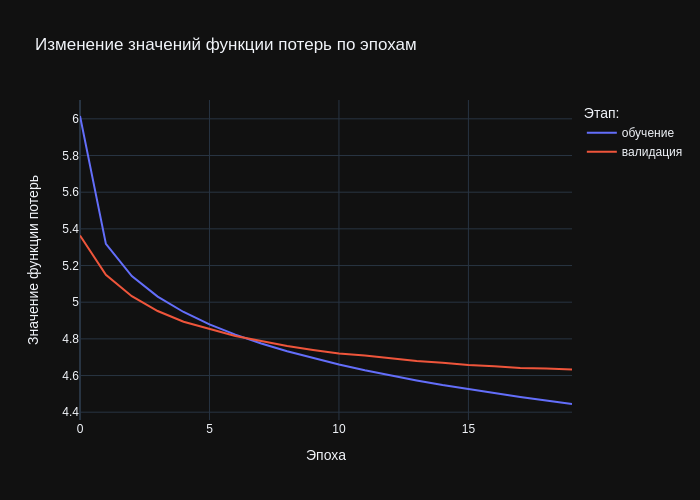

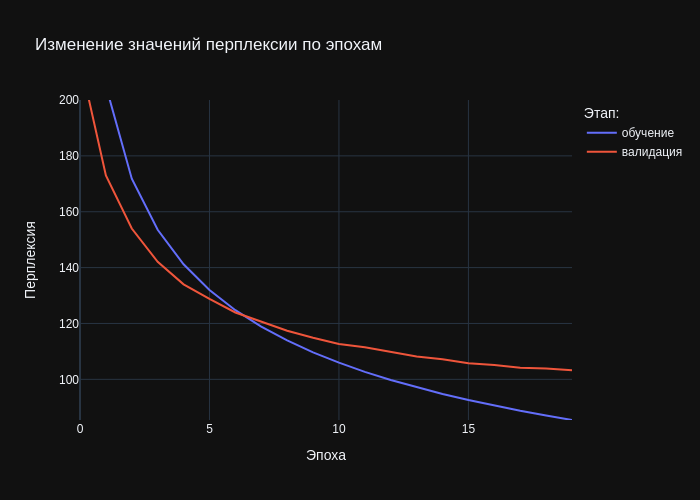

Значение перплексии на последней эпохе (валидация): 103.24222564697266


In [34]:
show_plots(model)

In [35]:
generate_sequence(model, starting_seq='the movie')

'<bos> the movie is a bit of a movie that is not a good movie . <eos>'

In [36]:
num_epoch = 20
arch = 'LSTM'
embedding_dim = 300
hidden_dim = 256
pad_index = word2ind['<pad>']
learning_rate = 0.0001
num_layers = 1
dropout_rate = 0

In [37]:
model =  LanguageModel(arch=arch,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       vocab_size=len(vocab),
                       pad_index=pad_index,
                       learning_rate=learning_rate,
                       num_layers=num_layers, 
                       dropout_rate=dropout_rate)

In [38]:
trainer = L.Trainer(max_epochs=num_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [39]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | metric     | Perplexity       | 0     
2 | embedding  | Embedding        | 12.0 M
3 | rnn        | LSTM             | 571 K 
4 | layer_norm | LayerNorm        | 512   
5 | linear     | Linear           | 65.8 K
6 | projection | Linear           | 10.3 M
7 | non_lin    | Tanh             | 0     
8 | dropout    | Dropout          | 0     
------------------------------------------------
22.9 M    Trainable params
0         Non-trainable params
22.9 M    Total params
91.680    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Посмотрим на результаты обучения:

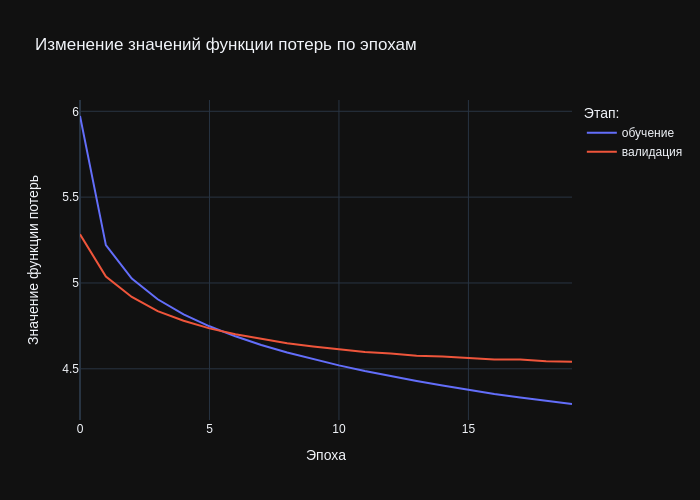

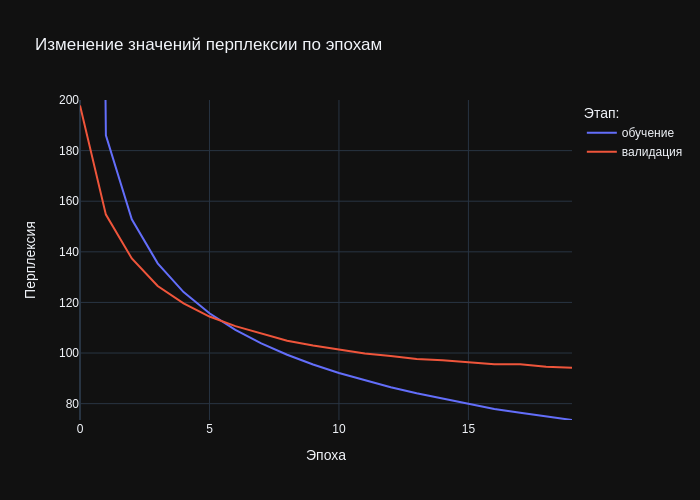

Значение перплексии на последней эпохе (валидация): 94.19798278808594


In [40]:
show_plots(model)

In [41]:
generate_sequence(model, starting_seq='the movie')

'<bos> the movie is a bit of a very good film . <eos>'

Теперь попробуем архитектуру `GRU`.

In [42]:
num_epoch = 20
arch = 'GRU'
embedding_dim = 300
hidden_dim = 256
pad_index = word2ind['<pad>']
learning_rate = 0.0001
num_layers = 1
dropout_rate = 0

In [43]:
model =  LanguageModel(arch=arch,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       vocab_size=len(vocab),
                       pad_index=pad_index,
                       learning_rate=learning_rate,
                       num_layers=num_layers, 
                       dropout_rate=dropout_rate)

In [44]:
trainer = L.Trainer(max_epochs=num_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | metric     | Perplexity       | 0     
2 | embedding  | Embedding        | 12.0 M
3 | rnn        | GRU              | 428 K 
4 | layer_norm | LayerNorm        | 512   
5 | linear     | Linear           | 65.8 K
6 | projection | Linear           | 10.3 M
7 | non_lin    | Tanh             | 0     
8 | dropout    | Dropout          | 0     
------------------------------------------------
22.8 M    Trainable params
0         Non-trainable params
22.8 M    Total params
91.108    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


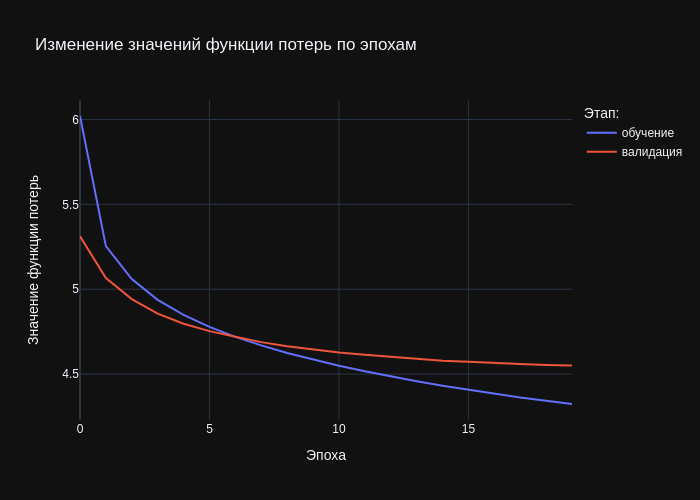

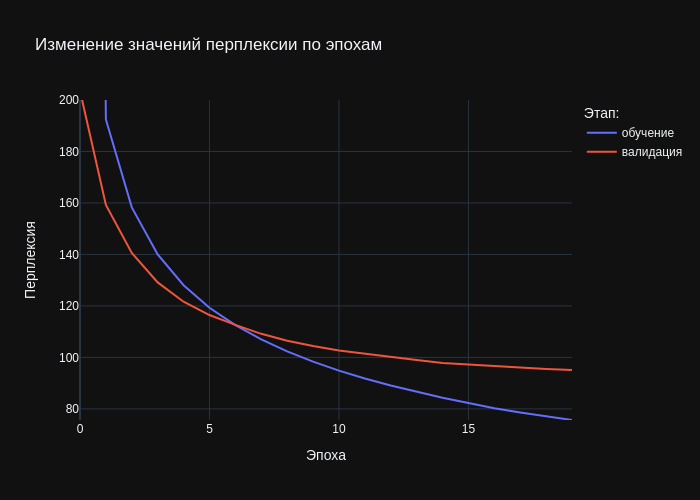

Значение перплексии на последней эпохе (валидация): 95.09111022949219


In [46]:
show_plots(model)

In [47]:
generate_sequence(model, starting_seq='the movie')

"<bos> the movie is a bit slow , and it 's not a good movie . <eos>"

#### Анализ результатов эксперимента

Сведём результаты эксперимента в таблицу.

| Модель | Перплексия | Сгенерированное предложение |
| ------ | ---------- | --------------------------- |
| `RNN`    | 103.24     | `<bos> the movie is a bit of a movie that is not a good movie . <eos>` |
| `LSTM`   |  94.20     | `<bos> the movie is a bit of a very good film . <eos>` |
| `GRU`    |  95.09     | `<bos> the movie is a bit slow , and it 's not a good movie . <eos>` |

Наименьшее значение метрики удалось достичь на архитектуре `LSTM`. При генерации текстов все три модели выдали короткие и близкие к естественным, хотя и странные предложения. Возьмём за основу архитектуру `LSTM` и попробуем снизить значение перплексии, посмотрим как это скажется на осмысленности генерируемого текста.

### Применение предобученных эмбедингов

Попробуем снизить перплексию за счёт применения предобученных эмбедингов на основе векторов `FastText`.

In [29]:
vectorizer = fasttext.load_model('cc.en.300.bin')

In [30]:
emb = [vectorizer.get_word_vector(word) for _, word in ind2word.items()]

In [31]:
del vectorizer

In [32]:
emb = torch.tensor(np.vstack(emb))

In [52]:
num_epoch = 20
arch = 'LSTM'
embedding_dim = 300
hidden_dim = 256
pad_index = word2ind['<pad>']
learning_rate = 0.0001
num_layers = 1
dropout_rate = 0

In [53]:
model =  LanguageModel(arch=arch,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       vocab_size=len(vocab),
                       pad_index=pad_index,
                       learning_rate=learning_rate,
                       num_layers=num_layers, 
                       dropout_rate=dropout_rate,
                       embedding_vectors=emb)

In [54]:
trainer = L.Trainer(max_epochs=num_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [55]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | metric     | Perplexity       | 0     
2 | embedding  | Embedding        | 12.0 M
3 | rnn        | LSTM             | 571 K 
4 | layer_norm | LayerNorm        | 512   
5 | linear     | Linear           | 65.8 K
6 | projection | Linear           | 10.3 M
7 | non_lin    | Tanh             | 0     
8 | dropout    | Dropout          | 0     
------------------------------------------------
22.9 M    Trainable params
0         Non-trainable params
22.9 M    Total params
91.680    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


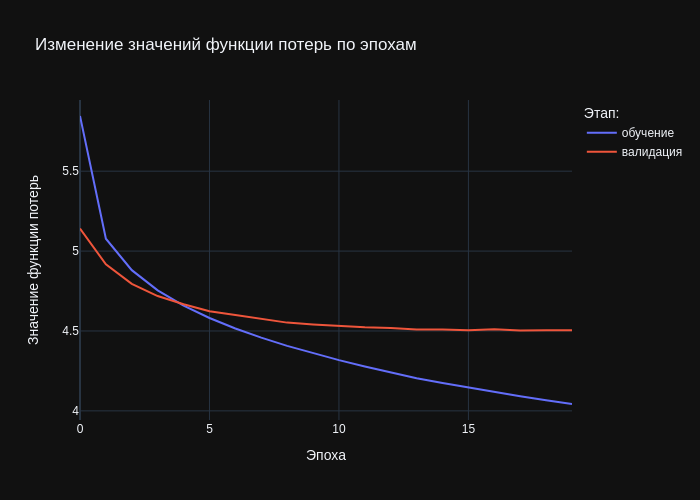

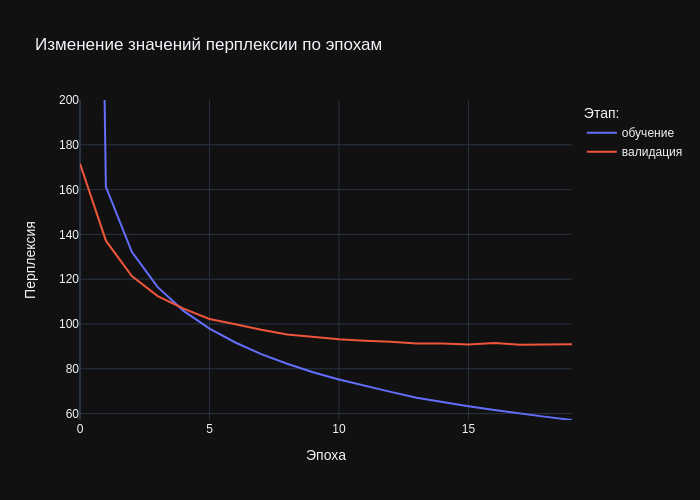

Значение перплексии на последней эпохе (валидация): 90.9212646484375


In [56]:
show_plots(model)

In [57]:
generate_sequence(model, starting_seq='the movie')

"<bos> the movie is a bit slow , but it 's not funny . <eos>"

#### Анализ результатов эксперимента

Дополним сравнительную таблицу.

| Модель | Перплексия | Сгенерированное предложение |
| ------ | ---------- | --------------------------- |
| `RNN`    | 103.24     | `<bos> the movie is a bit of a movie that is not a good movie . <eos>` |
| `LSTM`   |  94.20     | `<bos> the movie is a bit of a very good film . <eos>` |
| `GRU`    |  95.09     | `<bos> the movie is a bit slow , and it 's not a good movie . <eos>` |
| `LSTM` + `FastText`   |  90.92     | `<bos> the movie is a bit slow , but it 's not funny . <eos>` |

Перплексия заметно снизилась по сравнению с `LSTM`-моделью без предобученных эмбедингов, а сгенерированное предложение кажется чуть более осмысленным. Продолжим наши эксперименты.

### Увеличение скрытого представления

Возможно размер скрытого представления слишком мал для такого рода задачи. Попробуем его увеличить.

In [58]:
num_epoch = 20
arch = 'LSTM'
embedding_dim = 300
hidden_dim = 512
pad_index = word2ind['<pad>']
learning_rate = 0.0001
num_layers = 1
dropout_rate = 0

In [59]:
model =  LanguageModel(arch=arch,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       vocab_size=len(vocab),
                       pad_index=pad_index,
                       learning_rate=learning_rate,
                       num_layers=num_layers, 
                       dropout_rate=dropout_rate,
                       embedding_vectors=emb)

In [60]:
trainer = L.Trainer(max_epochs=num_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [61]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | metric     | Perplexity       | 0     
2 | embedding  | Embedding        | 12.0 M
3 | rnn        | LSTM             | 1.7 M 
4 | layer_norm | LayerNorm        | 1.0 K 
5 | linear     | Linear           | 262 K 
6 | projection | Linear           | 20.5 M
7 | non_lin    | Tanh             | 0     
8 | dropout    | Dropout          | 0     
------------------------------------------------
34.5 M    Trainable params
0         Non-trainable params
34.5 M    Total params
137.816   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


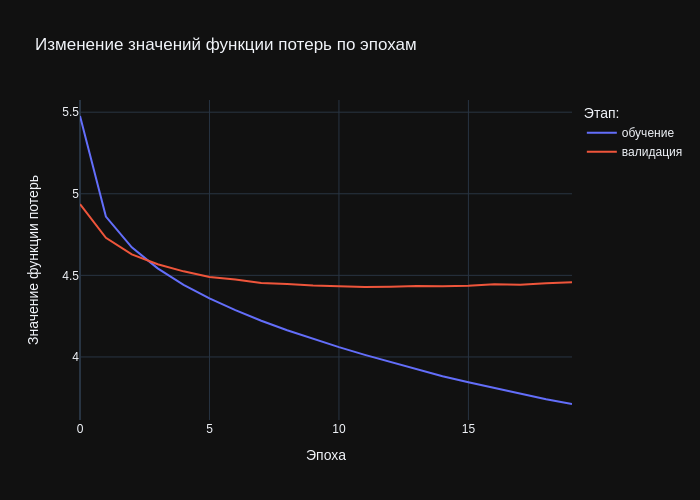

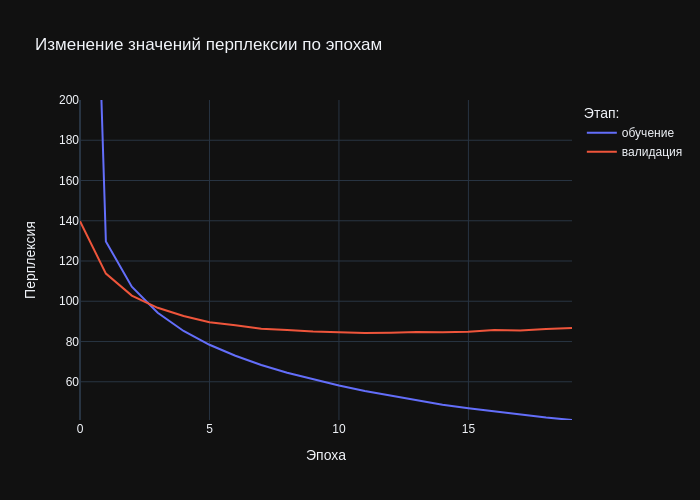

Значение перплексии на последней эпохе (валидация): 86.74658966064453


In [62]:
show_plots(model)

In [63]:
generate_sequence(model, starting_seq='the movie')

'<bos> the movie is a very good movie . <eos>'

In [64]:
num_epoch = 20
arch = 'LSTM'
embedding_dim = 300
hidden_dim = 1024
pad_index = word2ind['<pad>']
learning_rate = 0.0001
num_layers = 1
dropout_rate = 0

In [65]:
model =  LanguageModel(arch=arch,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       vocab_size=len(vocab),
                       pad_index=pad_index,
                       learning_rate=learning_rate,
                       num_layers=num_layers, 
                       dropout_rate=dropout_rate,
                       embedding_vectors=emb)

In [66]:
trainer = L.Trainer(max_epochs=num_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [67]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | metric     | Perplexity       | 0     
2 | embedding  | Embedding        | 12.0 M
3 | rnn        | LSTM             | 5.4 M 
4 | layer_norm | LayerNorm        | 2.0 K 
5 | linear     | Linear           | 1.0 M 
6 | projection | Linear           | 41.0 M
7 | non_lin    | Tanh             | 0     
8 | dropout    | Dropout          | 0     
------------------------------------------------
59.5 M    Trainable params
0         Non-trainable params
59.5 M    Total params
237.953   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


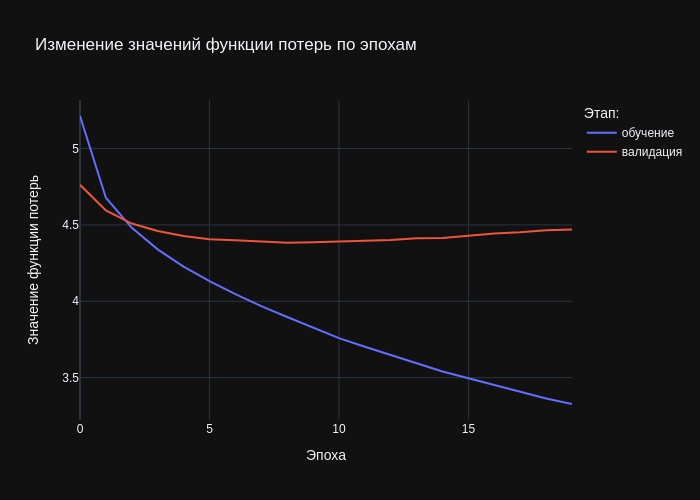

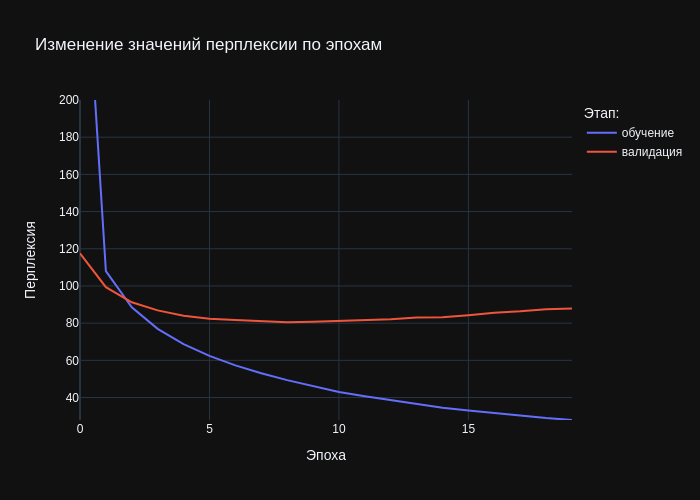

Значение перплексии на последней эпохе (валидация): 87.86258697509766


In [68]:
show_plots(model)

In [69]:
generate_sequence(model, starting_seq='the movie')

'<bos> the movie is a bit of a letdown . <eos>'

#### Анализ результатов эксперимента

Дополним сравнительную таблицу.

| Модель | Перплексия | Сгенерированное предложение |
| ------ | ---------- | --------------------------- |
| `RNN`    | 103.24     | `<bos> the movie is a bit of a movie that is not a good movie . <eos>` |
| `LSTM`   |  94.20     | `<bos> the movie is a bit of a very good film . <eos>` |
| `GRU`    |  95.09     | `<bos> the movie is a bit slow , and it 's not a good movie . <eos>` |
| `LSTM` + `FastText`   |  90.92     | `<bos> the movie is a bit slow , but it 's not funny . <eos>` |
| `LSTM` + `FT`, `hidden_dim`: 512   |  86.75    | `<bos> the movie is a very good movie . <eos>` |
| `LSTM` + `FT`, `hidden_dim`: 1024   |  87.86    | `<bos> the movie is a bit of a letdown . <eos>` |

Мы снизили значение метрики, но при этом обе модели переобучились (это особенно заметно на модели с `hidden_dim`=1024). 

### Увеличение количества рекуррентных слоёв и применение `dropout`

Попробуем бороться с переобучением за счёт дополнительной операции `dropout` внутри рекуррентного слоя. Для этого нам придётся также увеличить количетсво рекуррентных слоёв.

In [47]:
num_epoch = 20
arch = 'LSTM'
embedding_dim = 300
hidden_dim = 512
pad_index = word2ind['<pad>']
learning_rate = 0.0001
num_layers = 2
dropout_rate = 0.1

In [48]:
model =  LanguageModel(arch=arch,
                       embedding_dim=embedding_dim,
                       hidden_dim=hidden_dim, 
                       vocab_size=len(vocab),
                       pad_index=pad_index,
                       learning_rate=learning_rate,
                       num_layers=num_layers, 
                       dropout_rate=dropout_rate,
                       embedding_vectors=emb)

In [49]:
trainer = L.Trainer(max_epochs=num_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [50]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | metric     | Perplexity       | 0     
2 | embedding  | Embedding        | 12.0 M
3 | rnn        | LSTM             | 3.8 M 
4 | layer_norm | LayerNorm        | 1.0 K 
5 | linear     | Linear           | 262 K 
6 | projection | Linear           | 20.5 M
7 | non_lin    | Tanh             | 0     
8 | dropout    | Dropout          | 0     
------------------------------------------------
36.6 M    Trainable params
0         Non-trainable params
36.6 M    Total params
146.221   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


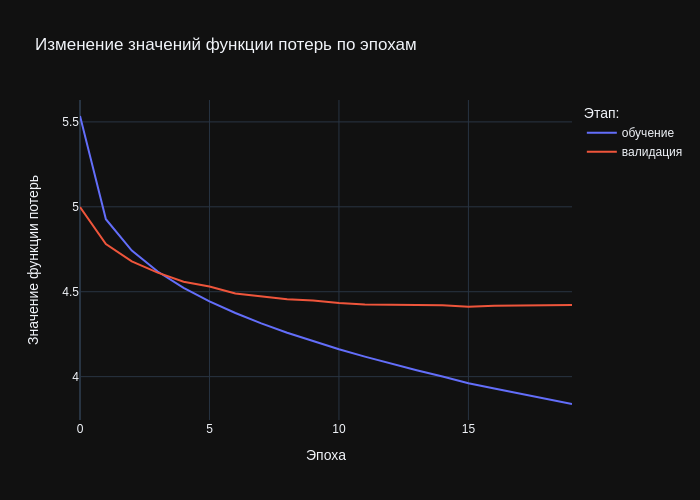

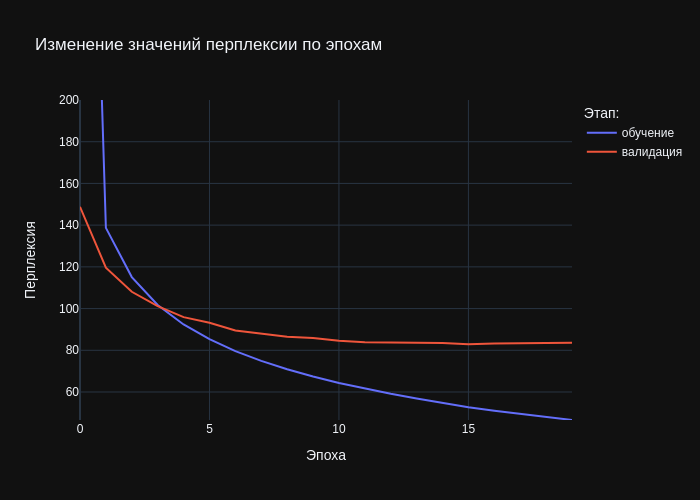

Значение перплексии на последней эпохе (валидация): 83.6721420288086


In [51]:
show_plots(model)

In [52]:
generate_sequence(model, starting_seq='the movie')

'<bos> the movie is a bit slow and the pace is very slow and the story is very good . <eos>'

#### Анализ результатов эксперимента

Дополним сравнительную таблицу.

| Модель | Перплексия | Сгенерированное предложение |
| ------ | ---------- | --------------------------- |
| `RNN`    | 103.24     | `<bos> the movie is a bit of a movie that is not a good movie . <eos>` |
| `LSTM`   |  94.20     | `<bos> the movie is a bit of a very good film . <eos>` |
| `GRU`    |  95.09     | `<bos> the movie is a bit slow , and it 's not a good movie . <eos>` |
| `LSTM` + `FastText`   |  90.92     | `<bos> the movie is a bit slow , but it 's not funny . <eos>` |
| `LSTM` + `FT`, `hidden_dim`: 512   |  86.75    | `<bos> the movie is a very good movie . <eos>` |
| `LSTM` + `FT`, `hidden_dim`: 1024   |  87.86    | `<bos> the movie is a bit of a letdown . <eos>` |
| `LSTM` + `FT`, `h_d`: 512, `n_layers`: 2, `dropout`   |  83.67    | `<bos> the movie is a bit slow and the pace is very slow and the story is very good . <eos>` |

Нам удалось победить переобучение и дополнительно снизить значение метрики. Прекрасно. Теперь попробуем использовать эту же модель для расчёта перплексии на тестовых данных.

## Тестирование

Возьмём модель, показавшую нилучшее значение перплексии на валидационных данных и рассчитаем значение метрики на тестовых данных.

In [53]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.423184871673584     │
│        test_metric        │     83.7791976928711      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.423184871673584, 'test_metric': 83.7791976928711}]

Чтож, перплексия на тестовых данных получилась лишь слегка выше перплексии на валидационных данных. Очень хорошо.

## Вывод

В данном проекте мы решали задачу языкового моделирования. Мы обучили несколько нейросетевых моделей предсказывать слова на основе предыдущего текста. Качество предсказаний мы оценивали по [перплексии](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%BF%D0%BB%D0%B5%D0%BA%D1%81%D0%B8%D1%8F). Обучение моделей производилось на наборе данных, составленном из комментариев на сервисе [IMDB](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

Мы предобработали данные, разбили их на отдельные предложения и сформировали словарь из 40 тысяч наиболее часто встречающихся слов. В этот словарь мы также добавили служебные слова-токены:
* `<unk>` — токен для замены слов, отсутствующих в словаре *(unknown)*
* `<bos>` — токен начала предложения *(begin of sentence)*
* `<eos>` — токен конца предложения *(end of sentence)*
* `<pad>` — токен паддинга *(padding)*

Полученные таким образом данные были собраны в модуль, содержащий обучающую, валидационную и тестовую выборки.

Для проведения экспериментов мы описали класс базовой модели. Базовая модель была представлена следующими слоями:

* слой эмбедингов
* рекуррентный слой (`RNN`, `LSTM` или `GRU`)
* слой нормализации
* линейный слой c `dropout`
* нелинейный слой
* слой получения предсказаний

Взяв за основу базовую модель мы провели следующие эксперименты:
1. сравнили архитектуры `RNN`, `LSTM` и `GRU`
2. попробовали использовать предобученные эмбединги на основе векторов `FastText`
3. попробовали увеличить размер скрытого представления
4. увеличили количество рекуррентных слоёв и добавили `dropout`

Результаты экспериментов представлены в таблице:

| Модель | Перплексия | Сгенерированное предложение |
| ------ | ---------- | --------------------------- |
| `RNN`    | 103.24     | `<bos> the movie is a bit of a movie that is not a good movie . <eos>` |
| `LSTM`   |  94.20     | `<bos> the movie is a bit of a very good film . <eos>` |
| `GRU`    |  95.09     | `<bos> the movie is a bit slow , and it 's not a good movie . <eos>` |
| `LSTM` + `FastText`   |  90.92     | `<bos> the movie is a bit slow , but it 's not funny . <eos>` |
| `LSTM` + `FT`, `hidden_dim`: 512   |  86.75    | `<bos> the movie is a very good movie . <eos>` |
| `LSTM` + `FT`, `hidden_dim`: 1024   |  87.86    | `<bos> the movie is a bit of a letdown . <eos>` |
| `LSTM` + `FT`, `h_d`: 512, `n_layers`: 2, `dropout`   |  83.67    | `<bos> the movie is a bit slow and the pace is very slow and the story is very good . <eos>` |

Из вышеприведённой таблицы видно, что наименьшего значения целевой метрики на валидационных данных удалось достичь при использовании двухслойной `LSTM` с `dropout` с предобученными эмбедингами, полученными на основе векторов `FastText`, и увеличенным скрытым представлением. Данная модель была использована для получения значения перплексии на тестовых данных: 83.78, что немногим больше значения на валидационных данных.

Из таблицы также видно, что все модели генерируют текст, похожий на осмысленный, но довольно странный. Единственное исключение — `<bos> the movie is a bit of a letdown . <eos>`. Это может быть связано с тем, что во всех случаях мы использовали жадный алгоритм выбора следующего слова, возможно применение других алгоритмов позволило бы немного повысить качество создаваемого текста. Кроме того, можно попробовать обучить нашу модель на расширенной выборке, в которую можно включить 50 тысяч комментариев из набора `unsupervised`. Однако для получения наилучших результатов следует использовать более современные модели на основе механизма внимания, например, трансформеры.